In [1]:
#General libraries
import os, argparse
import pickle
#from sklearn.decomposition import PCA
import numpy as np

#Torch libraries
import torch 
from torch import nn

#Custom libraries
#from load_datasets import load_dataset, create_dataloaders
from utils import Train_val_split, Dynamics_Dataset, Test_Dynamics_Dataset
from utils import fix_random_seeds,to_np
#from source.ide_func import NNIDEF, NeuralIDE
#from IE_source.solver import IESolver_monoidal
import IE_source.kernels as kernels
from IE_source.experiments import Full_experiment_AttentionalIE_PDE
from torch.utils.data import SubsetRandomSampler
from IE_source.kernels import model_blocks

from IE_source.Attentional_IE_solver import masking_function, Integral_attention_solver

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
    

parser = argparse.ArgumentParser(description='Neural IE')
parser.add_argument('-root_path', metavar='DIR', default='',
                    help='path to dataset')
parser.add_argument('-dataset-name', default='stl10',
                    help='dataset name', choices=['acrobot_dataset'])

parser.add_argument('-j', '--workers', default=12, type=int, metavar='N',
                    help='number of data loading workers (default: 32)')
parser.add_argument('--epochs', default=3000, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch_size', default=20, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--fp16-precision', action='store_true',
                    help='Whether or not to use 16-bit precision GPU training.')

parser.add_argument('--out_dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--log-every-n-steps', default=100, type=int,
                    help='Log every n steps')
parser.add_argument('--temperature', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')
parser.add_argument('--n-views', default=2, type=int, metavar='N',
                    help='Number of views for contrastive learning training.')
parser.add_argument('--gpu-index', default=0, type=int, help='Gpu index.')
parser.add_argument('--model', default='simclr', choices=['simclr','lipschitz_simclr','vae','gan'], 
                    help='Models to be used')
parser.add_argument('--mode', default='train', choices=['train','evaluate'], 
                    help='Set to ''evaluate'' if inference is desired')
parser.add_argument('--training_split', default=0.25,type=float, 
                    help='Fraction of the samples that will be used for validation')
parser.add_argument('--resume_from_checkpoint', default=None, 
                    help='Give string to run number. Ex: "run12"')
parser.add_argument('--plot_freq', default=1, type=int,help='')
parser.add_argument('--experiment_name', default=None,help='')


_StoreAction(option_strings=['--experiment_name'], dest='experiment_name', nargs=None, const=None, default=None, type=None, choices=None, required=False, help='', metavar=None)

In [2]:
'''
Use args.mode = 'train' to train the model, and args.mode = 'evaluate' to test it. 
args.resume_from_checkpoint = 'run#' allows to load a model, either for continue
training, or for testing it.
'''
args = parser.parse_args("")
args.model='nie'
args.mode='train'
#args.mode = 'evaluate'
args.dataset_name = 'integral_equations'
args.seed = 7
args.experiment_name = 'Burgers_test-longT-2'
args.plot_freq = 10
args.device = device
args.num_dim_plot = 2
args.lr = 1e-3
args.min_lr=1e-7
args.T_max = 51
args.plat_patience = 10
args.factor = 0.5
args.lr_scheduler = 'CosineAnnealingLR'
#args.resume_from_checkpoint = 'run1'
fix_random_seeds(args.seed)
args.perturbation_to_obs0=None
args.training_split=0.2
args.smoothing_factor=.5

In [3]:
args.kernel_split = True
args.free_func_nn = False
args.kernel_type_nn = True
args.G_NN = True
args.num_internal_points = 100 
args.plot_F_func = False
args.f_nn = False
args.max_iterations=3
args.sampling_points=100 
args.time_points=2  
args.support_tensors=True
args.support_test=False
args.test_points=50
args.combine_points=False
args.fourier_transform = False
args.linear_decoder = False
args.plot_as_image = True
args.plot_eval = False

In [4]:
args.n_batch=32

In [5]:
'''
Architecture of the transformer used for quadrature of integrals.
'''
args.dim = 16
args.dim_emb=32
args.n_head=2
args.n_blocks=2
args.n_ff=64
args.attention_type='galerkin'
args.final_block=False

In [6]:
import matplotlib.pyplot as plt

In [7]:
import scipy.io as spio

In [8]:
import mat73

# Burgers dataset has shape explained in https://github.com/zongyi-li/fourier_neural_operator. 1k samples for grid with size of 8192.

# Navier-Stokes dataset same link as above

In [9]:
'''
burgers_t=# gives the number of times points for the dynamics.
In the article we tested 10, 15, 25.
'''
Eqn_type = 'Burgers'
burgers_t=25
args.burgers_t=burgers_t


In [10]:
if Eqn_type == 'Burgers':
    if args.mode=='train':
        Data = torch.load('Burgers_1k_t400')
    else:
        print('loading test set')
        Data = torch.load('Burgers_Data_N200_t400')
else:
    Data = mat73.loadmat('Navier-Stokes_V1e-3_N5000_T50.mat')


loading test set


In [11]:
Data

tensor([[[ 0.0000,  0.0104,  0.0103,  ...,  0.0087,  0.0087,  0.0087],
         [ 0.0000,  0.0100,  0.0099,  ...,  0.0081,  0.0081,  0.0081],
         [ 0.0000,  0.0096,  0.0094,  ...,  0.0075,  0.0075,  0.0075],
         ...,
         [ 0.0000,  0.0114,  0.0114,  ...,  0.0104,  0.0103,  0.0103],
         [ 0.0000,  0.0110,  0.0110,  ...,  0.0098,  0.0098,  0.0098],
         [ 0.0000,  0.0107,  0.0107,  ...,  0.0093,  0.0092,  0.0092]],

        [[ 0.0000, -0.1633, -0.1637,  ..., -0.1145, -0.1144, -0.1143],
         [ 0.0000, -0.1642, -0.1646,  ..., -0.1142, -0.1141, -0.1140],
         [ 0.0000, -0.1651, -0.1656,  ..., -0.1138, -0.1138, -0.1137],
         ...,
         [ 0.0000, -0.1606, -0.1610,  ..., -0.1154, -0.1154, -0.1153],
         [ 0.0000, -0.1615, -0.1619,  ..., -0.1151, -0.1150, -0.1149],
         [ 0.0000, -0.1624, -0.1628,  ..., -0.1148, -0.1147, -0.1146]],

        [[ 0.0000,  0.4229,  0.4203,  ...,  0.1074,  0.1072,  0.1070],
         [ 0.0000,  0.4253,  0.4227,  ...,  0

In [12]:
if Eqn_type == 'Navier-Stokes' or burgers_t==2:
    Data['a'].shape

In [13]:
if Eqn_type == 'Burgers' and burgers_t==2:
    Data['a_smooth'].shape

In [14]:
if Eqn_type == 'Burgers' and burgers_t==2:
    Data['a_smooth_x'].shape

In [15]:
if Eqn_type == 'Navier-Stokes' or burgers_t==2:
    Data['u'].shape

In [16]:
if Eqn_type == 'Burgers' and burgers_t>2:
     Data.shape

In [17]:
if Eqn_type == 'Navier-Stokes' or burgers_t==2:
    Data_u = torch.from_numpy(Data['u'])

In [18]:
if Eqn_type == 'Navier-Stokes' or burgers_t==2:
    Data_a = torch.from_numpy(Data['a'])

In [19]:
if Eqn_type == 'Navier-Stokes' or burgers_t==2:
    Data_u.shape

In [20]:
if Eqn_type == 'Navier-Stokes' or burgers_t==2:
    Data_a.shape

In [21]:
if Eqn_type == 'Burgers' and burgers_t>2:
    Data.shape

In [22]:
'''
n_points=# gives the spatial resolution.
In the article we tested 256, 512.
'''

t_max = 1 
t_min = 0
n_points = 512

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack(index_np[:, None])
times_np = np.linspace(t_min, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])

###########################################################
times = torch.from_numpy(times_np[:, :, None]).to(device)
times = times.flatten().float()
###########################################################
args.time_interval=t_min, t_max

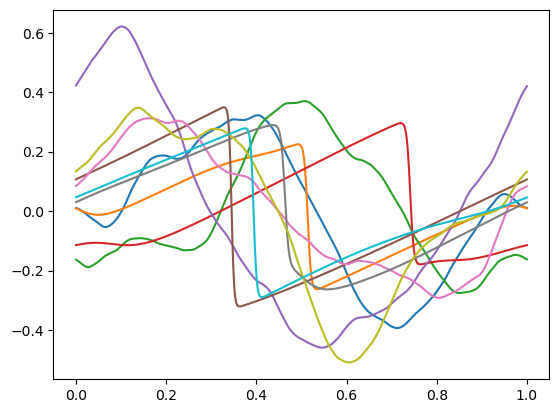

In [23]:
#Plot some of the data to visualize it
if Eqn_type == 'Burgers' and burgers_t==2:
    for i in range(10):
        plt.plot(torch.linspace(0,1,8192),Data_a[i,:])
        plt.plot(torch.linspace(0,1,8192),Data_u[i,:])
elif Eqn_type == 'Burgers' and burgers_t>2:
    for i in range(5):
        plt.plot(torch.linspace(0,1,Data.shape[1]),Data[i,:,1])
        plt.plot(torch.linspace(0,1,Data.shape[1]),Data[i,:,-1])
else:
    for i in range(10):
        plt.plot(torch.linspace(0,1,50),Data_u[i,17,17,:])

In [24]:
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)

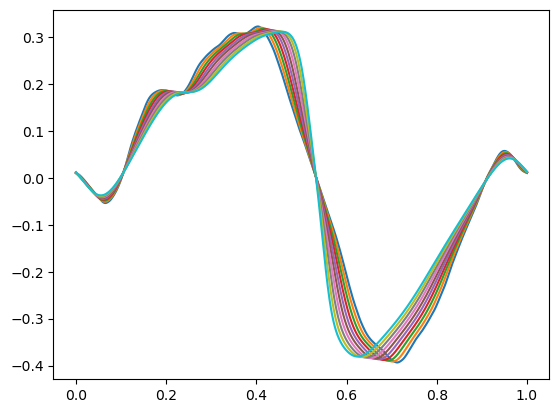

In [25]:
#visualize few times
if Eqn_type == 'Burgers' and burgers_t>2:
    for i in range(1,100,10):
        #plt.figure(i)
        plt.plot(torch.linspace(0,1,Data.shape[1]),Data[0,:,i],label='Data'+str(i))
        #plt.legend()

In [26]:
Data.shape

torch.Size([200, 1024, 401])

In [27]:
if burgers_t>2:
    Data = Data[:,:,:400]

In [28]:
if Eqn_type == 'Burgers' and burgers_t==2:
    for i in range(1024):
        Data_i0 = Data_a[i:i+1,:].unsqueeze(-1)
        Data_i1 = Data_u[i:i+1,:].unsqueeze(-1)
        if i == 0:
            Data = torch.cat([Data_i0,Data_i1],-1)
        else:
            Data = torch.cat([Data,torch.cat([Data_i0,Data_i1],-1)])
        
    
elif Eqn_type == 'Burgers' and burgers_t>2:
    pass
else:
    Data = Data_u[:10,:,:,:]

In [29]:
Data.shape

torch.Size([200, 1024, 400])

In [30]:
Data = Data.to(device)

In [31]:
Data = Data.float()

In [32]:
ids = np.tile(np.linspace(0,Data.shape[1]-1,num=n_points, dtype=np.int64),(Data.shape[1],1))

In [33]:
ids[0]

array([   0,    2,    4,    6,    8,   10,   12,   14,   16,   18,   20,
         22,   24,   26,   28,   30,   32,   34,   36,   38,   40,   42,
         44,   46,   48,   50,   52,   54,   56,   58,   60,   62,   64,
         66,   68,   70,   72,   74,   76,   78,   80,   82,   84,   86,
         88,   90,   92,   94,   96,   98,  100,  102,  104,  106,  108,
        110,  112,  114,  116,  118,  120,  122,  124,  126,  128,  130,
        132,  134,  136,  138,  140,  142,  144,  146,  148,  150,  152,
        154,  156,  158,  160,  162,  164,  166,  168,  170,  172,  174,
        176,  178,  180,  182,  184,  186,  188,  190,  192,  194,  196,
        198,  200,  202,  204,  206,  208,  210,  212,  214,  216,  218,
        220,  222,  224,  226,  228,  230,  232,  234,  236,  238,  240,
        242,  244,  246,  248,  250,  252,  254,  256,  258,  260,  262,
        264,  266,  268,  270,  272,  274,  276,  278,  280,  282,  284,
        286,  288,  290,  292,  294,  296,  298,  3

In [34]:
'''
IDs of the time stamps used for training, or testing. Testing will use twice as many stamps,
since the task is interpolation.
'''
if args.mode=='train': 
    if burgers_t>2:
        t_ids = np.tile(np.linspace(1,Data.shape[-1]-1,num=burgers_t, dtype=np.int64),(Data.shape[1],1))
        print(t_ids[0])
else:
    t_ids = np.tile(np.linspace(1,int(Data.shape[-1])-1,num=2*burgers_t, dtype=np.int64),(Data.shape[1],1))
    print(t_ids[0])

[  1   9  17  25  33  41  49  57  65  74  82  90  98 106 114 122 130 139
 147 155 163 171 179 187 195 204 212 220 228 236 244 252 260 269 277 285
 293 301 309 317 325 334 342 350 358 366 374 382 390 399]


In [35]:
Data = Data[:,ids[0],:]

In [36]:
Data.shape

torch.Size([200, 512, 400])

In [37]:
if burgers_t>2:
    Data = Data[:,:,t_ids[0]]

In [38]:
Data.shape

torch.Size([200, 512, 50])

In [39]:
'''
These are the number of points used by the model internally to produce an output.
This is independent of the number of points that the model outputs, since it is
used only to sample points for the integrals. The output will be interpolated and
will give the prefixed number of points, which is smaller for training (since this
is an interpolation task).
'''
if burgers_t>2:
    args.time_points=2*burgers_t

In [40]:
Data.shape

torch.Size([200, 512, 50])

In [41]:
ts_integration = torch.linspace(0,1,400)[t_ids[0]]
print(ts_integration)
args.ts_integration = ts_integration

tensor([0.0025, 0.0226, 0.0426, 0.0627, 0.0827, 0.1028, 0.1228, 0.1429, 0.1629,
        0.1855, 0.2055, 0.2256, 0.2456, 0.2657, 0.2857, 0.3058, 0.3258, 0.3484,
        0.3684, 0.3885, 0.4085, 0.4286, 0.4486, 0.4687, 0.4887, 0.5113, 0.5313,
        0.5514, 0.5714, 0.5915, 0.6115, 0.6316, 0.6516, 0.6742, 0.6942, 0.7143,
        0.7343, 0.7544, 0.7744, 0.7945, 0.8145, 0.8371, 0.8571, 0.8772, 0.8972,
        0.9173, 0.9373, 0.9574, 0.9774, 1.0000])


In [42]:
'''
Initialize data and model.
'''
n_steps = 5000
print('Data.shape: ',Data.shape)

Data_splitting_indices = Train_val_split(np.copy(index_np),0)
Train_Data_indices = Data_splitting_indices.train_IDs()
Val_Data_indices = Data_splitting_indices.val_IDs()
print('\nlen(Train_Data_indices): ',len(Train_Data_indices))
print('Train_Data_indices: ',Train_Data_indices)
print('\nlen(Val_Data_indices): ',len(Val_Data_indices))
print('Val_Data_indices: ',Val_Data_indices)
Dataset = Dynamics_Dataset(Data,times)

Dataset_all = Test_Dynamics_Dataset(Data,times)

# For the sampler
train_sampler = SubsetRandomSampler(Train_Data_indices)
valid_sampler = SubsetRandomSampler(Val_Data_indices)
    

dataloaders = {'train': torch.utils.data.DataLoader(Dataset, sampler=train_sampler, batch_size = args.batch_size, drop_last=True),
               'val': torch.utils.data.DataLoader(Dataset, sampler=valid_sampler, batch_size = args.batch_size, drop_last=True),
               'test': torch.utils.data.DataLoader(Dataset_all, batch_size = len(np.copy(index_np))),
              }

model = model_blocks(args.dim+1,
                     args.dim_emb,
                     args.n_head,
                     args.n_blocks,
                     args.n_ff,
                     args.attention_type,
                     args.final_block,
                     dropout=0.1)

if torch.cuda.is_available():
    model = model.cuda()

Data.shape:  torch.Size([200, 512, 50])

len(Train_Data_indices):  512
Train_Data_indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 20

In [43]:
args.range_imshow = np.array([np.quantile(to_np(Data).flatten(), 0.05), np.quantile(to_np(Data).flatten(), 0.95)])

In [44]:
args.range_imshow

array([-0.37127168,  0.36326906])

Data.size()

In [45]:
exp_mode = 'Fredholm'

In [46]:
#Fredholm mode
mask = None

In [47]:
#Volterra mode
if exp_mode == 'Volterra':
    masking_map =  masking_function(lambda x: 0.,lambda x: x,n_batch=1)
    mask_times = times
    mask = masking_map.create_mask(mask_times)

In [48]:
print(mask)

None


In [49]:
args.n_patch = 64

In [50]:
'''
Create Encoder for latent space.
'''
Encoder = kernels.ConvNeuralNet1D(
                            1,
                            args.dim,
                            args.dim,
                            hidden_ff=32,
                            Data_shape1=n_points,
                            n_patch=args.n_patch
).to(args.device)

In [51]:
args.shapes = Encoder(Data[:4,:,:1].permute(0,2,1)).shape

In [52]:
args.n_points = args.shapes[-1]

In [53]:
class Decoder_NN(nn.Module):
    def __init__(self,in_dim,out_dim,shapes,NL=nn.ELU):
        super(Decoder_NN, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.n_layers = len(shapes) - 1
        self.shapes = shapes
        self.first = nn.Linear(in_dim,shapes[0])
        self.layers = nn.ModuleList([nn.Linear(shapes[i],shapes[i+1]) for i in range(self.n_layers)])
        self.last = nn.Linear(shapes[-1], out_dim)
        self.NL = NL(inplace=True) 
        
    def forward(self, y):
        y_in = y.permute(0,2,1,3)
        y_in = y_in.flatten(2,3)
        y = self.NL(self.first.forward(y_in))
        for layer in self.layers:
            y = self.NL(layer.forward(y))   
        y_out = self.last.forward(y)
        y = y_out.permute(0,2,1)

        return y

In [54]:
'''
Initialize decoder to go back in original space. 
'''
Decoder = Decoder_NN(args.shapes[-1]*args.dim,n_points,[64,128]).to(args.device)

In [55]:
kernels.flatten_kernel_parameters(model).shape[0]+kernels.flatten_kernel_parameters(Encoder).shape[0]+kernels.flatten_kernel_parameters(Decoder).shape[0]



160066

In [56]:
args.epochs=150

In [57]:
args.print_ts=False
if args.print_ts is True:
    args.freq_print_ts = int(args.epochs/500)*args.plot_freq

In [58]:
'''
Run experiment here. Either for training, or test (depending on args.mode above).
'''
Full_experiment_AttentionalIE_PDE(model,Encoder,Decoder,Data, times, index_np, mask, times, args, extrapolation_points=None)

Loading  nie/Burgers_test-longT-2/run16/model
Running in evaluation mode


  0%|          | 0/7 [00:00<?, ?it/s]/gpfs/gibbs/project/dijk/eaz29/conda_envs/notebook_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 2
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: Use

R2: 0.9756565269022685
MSE: 0.002946391
R2: 0.9765709360209462
MSE: 0.0023432162


/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 2
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 2
  warnings.warn(
 57%|█████▋    | 4/7 [00:00<00:00, 14.68it/s]

R2: 0.9784393150348516
MSE: 0.001979304
R2: 0.977019557925607
MSE: 0.0020371974


/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 2
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 2
  warnings.warn(
 86%|████████▌ | 6/7 [00:00<00:00, 15.15it/s]

R2: 0.9817691962718922
MSE: 0.0019572082
R2: 0.9765829718355452
MSE: 0.0023112858


/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 2
  warnings.warn(
100%|██████████| 7/7 [00:00<00:00, 15.71it/s]

R2: 0.9790966803000264
MSE: 0.0022748688
Average R2: 0.9778764548987339
Average MSE: 0.002264210189293538
